# Node Classification for Graph Neural networks using Pytorch Geometric

In [3]:
# Install required packages.
%%capture
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

In [4]:


# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()



## Cora Dataset
Using the pytorch geometric datasets this notebook will expore node classification. The dataset used will be cora. The cora data set The Cora dataset consists of __2708 scientific publications__ classified into one of seven classes. The citation network consists of __5429 links__. Each publication in the dataset is described by a __0/1-valued word vector__ indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of __1433 unique words__.

In [5]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


# Convolutional Graph Neural Network
- Using a convolutional graph neural network I will explore how to classify nodes

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [7]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
      super(GCN, self).__init__()
      torch.manual_seed(12345)
      self.conv1 = GCNConv(dataset.num_features, hidden_channels)
      self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)

        return x

class NodeClassification():
    def __init__(self, data, hidden_channels=16, lr=0.01, weight_decay=5e-4):
        self.model = GCN(hidden_channels)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.data = data
    
    def train(self):
        self.model.train()
        self.optimizer.zero_grad() #Clear Gradients
        out = self.model(self.data.x, self.data.edge_index) #Perform a single foward pass
        loss = self.criterion(out[self.data.train_mask], self.data.y[self.data.train_mask])  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        self.optimizer.step()  # Update parameters based on gradients.
        return loss

    def test(self):
        self.model.eval()
        out = self.model(self.data.x, self.data.edge_index)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        test_correct = pred[self.data.test_mask] == self.data.y[self.data.test_mask]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(self.data.test_mask.sum())  # Derive ratio of correct predictions.
        return test_acc

    def validate(self):
        self.model.eval()
        out = self.model(self.data.x, self.data.edge_index)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        val_correct = pred[self.data.val_mask] == self.data.y[self.data.val_mask]  # Check against ground-truth labels.
        val_acc = int(val_correct.sum()) / int(self.data.val_mask.sum())  # Derive ratio of correct predictions.
        return val_acc

    def visualize_model(self):
        self.model.eval()
        out = self.model(self.data.x, self.data.edge_index)
        print(out)
        visualize(out, color=self.data.y)



tensor([[-0.0038, -0.0024,  0.0023,  ...,  0.0015,  0.0020, -0.0034],
        [-0.0027,  0.0005,  0.0007,  ...,  0.0047,  0.0030, -0.0024],
        [-0.0023,  0.0003,  0.0003,  ...,  0.0028,  0.0010, -0.0027],
        ...,
        [ 0.0020,  0.0026,  0.0003,  ..., -0.0027,  0.0036, -0.0055],
        [ 0.0005, -0.0056, -0.0040,  ...,  0.0023, -0.0012, -0.0060],
        [-0.0014, -0.0049, -0.0040,  ...,  0.0023, -0.0015, -0.0060]],
       grad_fn=<AddBackward0>)


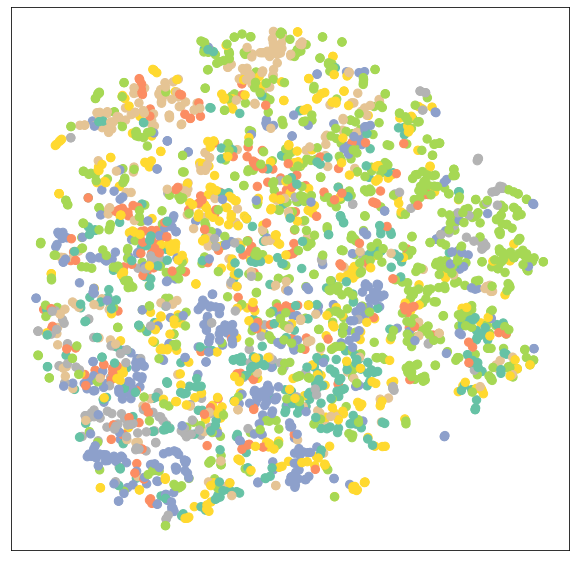

In [8]:
classifier = NodeClassification(data)
classifier.visualize_model()

In [71]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
for epoch in range(1, 201):
    loss = classifier.train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9451
Epoch: 002, Loss: 1.9384
Epoch: 003, Loss: 1.9307
Epoch: 004, Loss: 1.9227
Epoch: 005, Loss: 1.9126
Epoch: 006, Loss: 1.9076
Epoch: 007, Loss: 1.8917
Epoch: 008, Loss: 1.8809
Epoch: 009, Loss: 1.8728
Epoch: 010, Loss: 1.8616
Epoch: 011, Loss: 1.8453
Epoch: 012, Loss: 1.8397
Epoch: 013, Loss: 1.8237
Epoch: 014, Loss: 1.8057
Epoch: 015, Loss: 1.7979
Epoch: 016, Loss: 1.7808
Epoch: 017, Loss: 1.7667
Epoch: 018, Loss: 1.7555
Epoch: 019, Loss: 1.7436
Epoch: 020, Loss: 1.7184
Epoch: 021, Loss: 1.7126
Epoch: 022, Loss: 1.6845
Epoch: 023, Loss: 1.6717
Epoch: 024, Loss: 1.6673
Epoch: 025, Loss: 1.6353
Epoch: 026, Loss: 1.6181
Epoch: 027, Loss: 1.5962
Epoch: 028, Loss: 1.5723
Epoch: 029, Loss: 1.5708
Epoch: 030, Loss: 1.5370
Epoch: 031, Loss: 1.5162
Epoch: 032, Loss: 1.4948
Epoch: 033, Loss: 1.4713
Epoch: 034, Loss: 1.4589
Epoch: 035, Loss: 1.4479
Epoch: 036, Loss: 1.4377
Epoch: 037, Loss: 1.4271
Epoch: 038, Loss: 1.3644
Epoch: 039, Loss: 1.3658
Epoch: 040, Loss: 1.3363


In [72]:
test_acc = classifier.test()
print(f'Test Accuracy: {test_acc:.4f}')
val_acc = classifier.validate()
print(f'Validation Accuracy: {val_acc:.4f}')
classifier.visualize_model()

Test Accuracy: 0.8140


##Try increasing the number of hidden channels to see if preformance improves

In [9]:
classifier = NodeClassification(data, hidden_channels=50)

tensor([[-3.6341e-04,  1.2775e-03, -1.6333e-03,  ...,  2.3628e-03,
          3.8747e-04, -6.4577e-03],
        [-3.0222e-03,  4.0641e-03, -3.7365e-03,  ...,  2.3872e-04,
          4.6354e-03, -2.7220e-03],
        [ 1.0744e-03,  1.6712e-03, -1.8286e-03,  ..., -3.8180e-04,
          3.0525e-03, -1.0109e-03],
        ...,
        [-3.6439e-04,  8.7829e-03, -8.4399e-04,  ..., -1.5961e-03,
          5.1488e-03,  2.6505e-03],
        [ 1.5119e-03,  4.1148e-03,  6.3339e-05,  ...,  6.3949e-04,
          1.2806e-03, -3.2361e-03],
        [ 1.7111e-03,  1.7501e-03, -1.4616e-05,  ...,  8.3432e-04,
          6.8883e-04, -2.6766e-03]], grad_fn=<AddBackward0>)


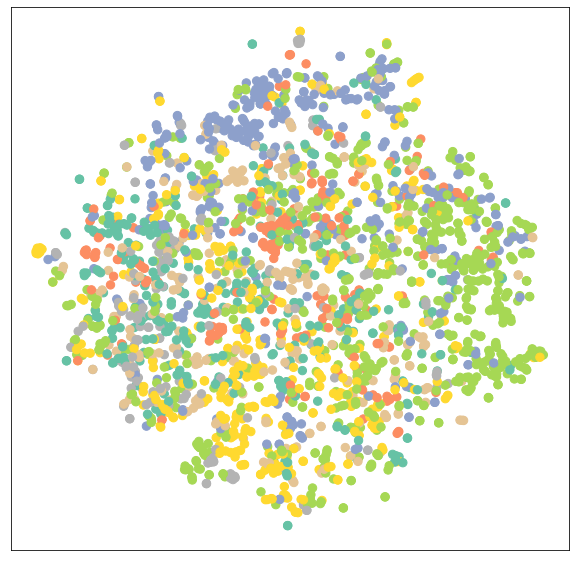

In [10]:
classifier.visualize_model()

In [11]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
for epoch in range(1, 201):
    loss = classifier.train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9370
Epoch: 003, Loss: 1.9279
Epoch: 004, Loss: 1.9156
Epoch: 005, Loss: 1.8979
Epoch: 006, Loss: 1.8801
Epoch: 007, Loss: 1.8671
Epoch: 008, Loss: 1.8465
Epoch: 009, Loss: 1.8237
Epoch: 010, Loss: 1.8050
Epoch: 011, Loss: 1.7810
Epoch: 012, Loss: 1.7572
Epoch: 013, Loss: 1.7242
Epoch: 014, Loss: 1.7082
Epoch: 015, Loss: 1.6686
Epoch: 016, Loss: 1.6563
Epoch: 017, Loss: 1.6131
Epoch: 018, Loss: 1.5733
Epoch: 019, Loss: 1.5423
Epoch: 020, Loss: 1.5148
Epoch: 021, Loss: 1.4842
Epoch: 022, Loss: 1.4504
Epoch: 023, Loss: 1.4223
Epoch: 024, Loss: 1.3718
Epoch: 025, Loss: 1.3372
Epoch: 026, Loss: 1.2903
Epoch: 027, Loss: 1.2638
Epoch: 028, Loss: 1.2336
Epoch: 029, Loss: 1.1918
Epoch: 030, Loss: 1.1570
Epoch: 031, Loss: 1.0984
Epoch: 032, Loss: 1.1015
Epoch: 033, Loss: 1.0411
Epoch: 034, Loss: 1.0182
Epoch: 035, Loss: 0.9786
Epoch: 036, Loss: 0.9399
Epoch: 037, Loss: 0.9056
Epoch: 038, Loss: 0.9009
Epoch: 039, Loss: 0.8945
Epoch: 040, Loss: 0.8224


In [12]:
test_acc = classifier.test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8080


In [13]:
val_acc = classifier.validate()
print(f'Validation Accuracy: {val_acc:.4f}')

Validation Accuracy: 0.7780


tensor([[-1.9583e+00, -4.4270e-01, -3.7181e-01,  ..., -1.6162e-01,
         -2.8666e+00, -1.0824e+00],
        [-3.9558e-02, -1.1983e+00, -1.8803e+00,  ...,  4.0037e+00,
         -1.2595e+00, -1.9628e+00],
        [-1.5524e-01, -7.6687e-01, -1.6956e+00,  ...,  3.1142e+00,
         -1.8759e+00, -2.1321e+00],
        ...,
        [ 1.4002e+00,  1.8120e+00, -2.6716e+00,  ..., -2.1455e+00,
          8.4968e-01, -3.8833e-01],
        [-1.3014e+00, -7.6869e-02, -5.5974e-01,  ...,  4.4724e-01,
         -2.5447e+00, -2.0068e+00],
        [-1.2301e+00,  1.4073e-04, -3.8510e-01,  ...,  2.2224e-01,
         -2.1341e+00, -1.8686e+00]], grad_fn=<AddBackward0>)


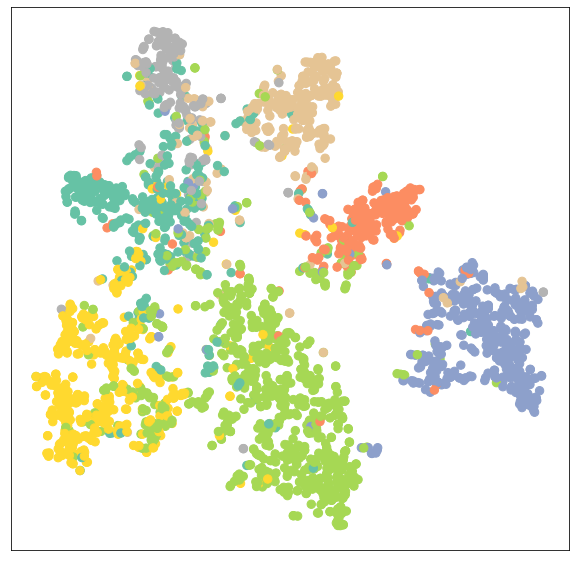

In [14]:
classifier.visualize_model()